# 🏪 Retail Sales Forecasting with Store Insights

## 🎯 Proje Amacı

Bu projede, Rossmann mağazalarının satış verileri kullanılarak günlük satış tahminleri yapılmıştır. Mağaza bilgileri, promosyon detayları ve tarihsel veriler birleştirilerek anlamlı özellikler oluşturulmuş; makine öğrenmesi modelleriyle gelecekteki satışlar tahmin edilmiştir.

---

## 📊 Kullanılan Veri Setleri

- `train.csv`: Geçmiş satış verileri (mağaza, tarih, promosyon, tatil vs.)
- `store.csv`: Her mağaza için sabit bilgiler (tipi, konumu, rekabet mesafesi vs.)
- `test.csv`: Tahmin yapılacak tarihler
- `sample_submission.csv`: Beklenen tahmin formatı

---

## ⚙️ Uygulanan Adımlar

1. **Veri Yükleme & İnceleme**
2. **Mağaza bilgileriyle birleştirme (`merge`)**
3. **Tarih sütunundan yeni özellikler üretme** (`Year`, `Month`, `WeekOfYear` vs.)
4. **Kategorik değişkenleri encoding ile sayısallaştırma**
5. **Eksik verilerin medyanla doldurulması**
6. **Random Forest Regressor ile model eğitimi**
7. **Satış tahminlerinin yapılması ve submission dosyası oluşturulması**

---

## 📈 Kullanılan Model

- **Model**: `RandomForestRegressor`
- **Neden?**: Karmaşık veri setlerinde hızlı, güçlü ve yorumlanabilir sonuçlar sunması
- **Alternatifler**: `XGBoost`, `LightGBM` (ileride test edilebilir)

---

## 🔚 Sonuç

Model, mağaza ve tarihsel bilgilerle tahmin yapabilecek duruma getirildi. Submission dosyası Kaggle yarışması için uygun formatta üretildi. Performans daha ileri modellerle artırılabilir.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [2]:
store_df = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
test_df = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
sample_submission_df = pd.read_csv('/kaggle/input/rossmann-store-sales/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', dtype={'StateHoliday': str}, low_memory=False)

In [3]:
train_df_merged = pd.merge(train_df, store_df, on='Store', how='left')
test_df_merged = pd.merge(test_df, store_df, on='Store', how='left')

train_df_merged['Date'] = pd.to_datetime(train_df_merged['Date'])
test_df_merged['Date'] = pd.to_datetime(test_df_merged['Date'])

print(train_df_merged.isnull().sum())
print(test_df_merged.isnull().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64
Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment              

In [4]:
for df in [train_df_merged, test_df_merged]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)


In [5]:
from sklearn.preprocessing import LabelEncoder

for df in [train_df_merged, test_df_merged]:
    df['StateHoliday'] = df['StateHoliday'].astype(str)
    df['PromoInterval'] = df['PromoInterval'].astype(str)

le_state = LabelEncoder()
le_promo = LabelEncoder()

for df in [train_df_merged, test_df_merged]:
    df['StateHoliday'] = le_state.fit_transform(df['StateHoliday'])
    df['PromoInterval'] = le_promo.fit_transform(df['PromoInterval'])

train_df_merged = pd.get_dummies(train_df_merged, columns=['StoreType', 'Assortment'])
test_df_merged = pd.get_dummies(test_df_merged, columns=['StoreType', 'Assortment'])


train_cols = set(train_df_merged.columns)
test_cols = set(test_df_merged.columns)

for col in train_cols - test_cols:
    test_df_merged[col] = 0
for col in test_cols - train_cols:
    train_df_merged[col] = 0

test_df_merged = test_df_merged[train_df_merged.columns.drop('Sales', errors='ignore')]


In [6]:
for df in [train_df_merged, test_df_merged]:
    df.fillna(df.median(numeric_only=True), inplace=True)


In [7]:
drop_cols = ['Sales', 'Customers', 'Date', 'Id']

X_train = train_df_merged.drop(columns=[col for col in drop_cols if col in train_df_merged.columns])
y_train = train_df_merged['Sales']

X_test = test_df_merged.drop(columns=[col for col in drop_cols if col in test_df_merged.columns])


In [8]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_test)
preds = np.maximum(0, preds)

submission = pd.DataFrame({'Id': test_df['Id'], 'Sales': preds})
submission.to_csv('submission.csv', index=False)
submission.head()

,Id,Sales
0,1,4384.28
1,2,7560.85
2,3,9096.23
3,4,8238.18
4,5,7692.28


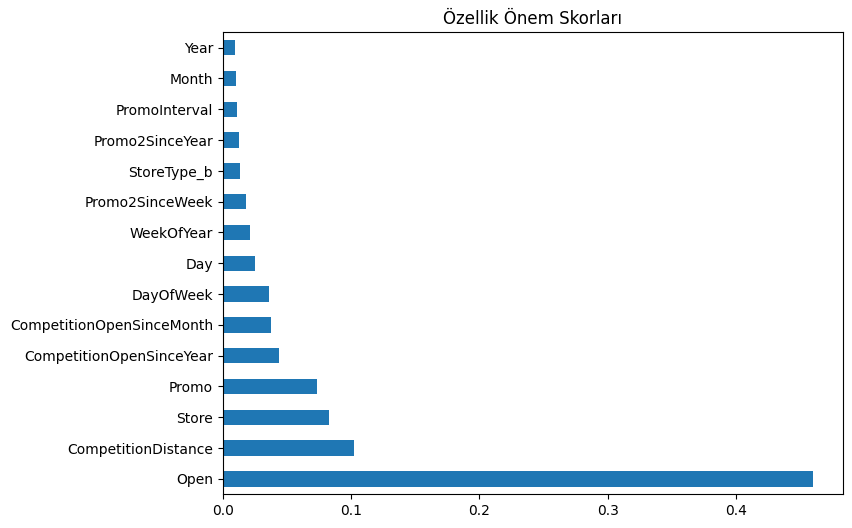

In [9]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(8, 6))
plt.title("Özellik Önem Skorları")
plt.show()